# 文档说明

这篇文档对应的内容是文本分类项目第一周结果展示,主要包括下面几个部分:
1. 比较百度中文分词和结巴分词的结果和效率
2. 探索数据分布与分析
3. 编码尝试与结果评估

    3.1 OneHot    
    3.2 Embedding与可视化

## 1. 百度中文分词和结巴分词的对比

#### 结论:
(提前上结论了,想了解详细信息的可以继续看下去,不感兴趣的直接跳过这节内容.)

- jieba分词在处理时间上优于百度中文分词,处理结果没有明显劣势.
- Baidu分词的结果可以用来丰富jieba的词典,增加jieba分词的可靠性.
- 最后采用的方案是使用Baidu分词的结果扩充jieba分词的字典,然后使用jieba分词对数据进行分词.

### 1.1 百度中文分词介绍
    百度中文分词是百度AI开放平台中一个可以免费调用的web api,可以实现对中文语句的分词.更多信息可以参考: http://ai.baidu.com.
    
### 1.2 jieba中文分词介绍
    jieba分词是一个免费的第三方python中文分词类库,可以在本地对中文语句进行分词操作.
    jieba分词提供了三种分词策略:
        a. 精确模式
        b. 全模式
        c. 搜索引擎模式
    更多信息可以参考: https://github.com/fxsjy/jieba

### 1.3 两种分词方式的性能(处理时间)对比
两种分词方式处理分词的位置不同,导致语句的处理时间会有数量级上的差别.
在进行百度分词api调用的时候,这里采用了爬虫框架Scrapy,利用其多线程技术最大化的减少web api调用对处理时间的影响.由于百度ai平台对免费调用的并发量有限制(5),所以爬虫的线程数固定在5条.

进行的具体操作如下:
- 对training.csv里的description内容进行分词.
- 分词结束使用相同的方法去除分词结果中的中文停用词.

| 分词工具 | 数据量 | 用时 |
| :-- | ---: | ---: |
| 百度中文分词 | 4773 | 55 min |
| jieba分词 | 4773 | 30 s |

### 1.4 两种分词处理结果对比
分词结果出来之后,随机挑选了前三个分类里的结果进行比较,得到如下结论:

| | 优点 | 缺点 |
| --- |--- | --- |
| 百度中文分词 | 可以很好的识别一些专业机构和行业标准 | 对某些常用词语组合分词效果不理想.比如"主营业务",分词结果为 '主', '营', '业务' |
| jieba分词 | 对常见词的分词处理比较适中 | 对专业机构和行业标准的识别不理想 |

比如:
#### 百度中文分词:

['合晟资产', '一家', '专注', '股票', '债券', '二级', '市场', '投资', '合格', '投资者', '提供', '专业', '资产', '管理', '服务', '企业', '公司', '业务范围', '包括', '资产', '管理', '投资', '咨询', '投资', '顾问', '服务', '公司', '管理', '私募基金', '产品', '包括', '股票型', '债券型', '资产', '管理', '计划', '证券投资', '基金', '管理', '总', '资产', '规模', '80亿元', '中国证券投资基金业协会', '数据', '公司', '管理', '私募证券投资基金', '顾问', '管理', '类', '规模', '较大', '公司', '管理', '规模', '处于', '50亿元', '第一', '梯队']

#### jieba分词:

['合晟', '资产', '一家', '专注', '股票', '债券', '二级', '市场', '投资', '合格', '投资者', '提供', '专业', '资产', '管理', '服务', '企业', '公司', '业务范围', '包括', '资产', '管理', '投资', '咨询', '投资', '顾问', '服务', '公司', '管理', '私募', '基金', '产品', '包括', '股票', '型', '债券', '型', '资产', '管理', '计划', '证券', '投资', '基金', '管理', '总资产', '规模', '80', '亿元', '中国', '证券', '投资', '基金业', '协会', '数据', '公司', '管理', '私募', '证券', '投资', '基金', '顾问', '管理', '类', '规模', '较大', '公司', '管理', '规模', '处于', '50', '亿元', '第一', '梯队']


### 1.5 那些年踩过的坑

这里的坑主要是百度中文分词里的.
1. 百度中文分词只支持GBK编码,而Scrapy原生的api会对中文语句进行处理,导致传到服务器的时候编码格式不对,从而无法输出结果.
解决方案: 重写Scrapy中间件,使用python的requests库进行调用.

2. 百度中文分词无法处理一些特殊符号.
即便已经对所有语句进行了GBK编码,但是有些字符百度还是无法处理.
解决方案: 对所有出错的语句进行分析,把特殊字符找出来,在上传到服务器之前去除特殊字符.

## 2. 数据探索

### 2.1 查看数据分布
查看每个分类的实例分布均匀不均匀

In [1]:
import nltk
from nltk import word_tokenize, sent_tokenize
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import pandas as pd
from bokeh.io import output_notebook
from bokeh.plotting import show, figure
import jieba
import matplotlib.pyplot as plt
%matplotlib inline

training_path = '/home/alvin/!Final_Project/training_with_tokens.xlsx'
testing_path = '/home/alvin/!Final_Project/testing_with_tokens.xlsx'

df_train = pd.read_excel(training_path, names=['class', 'descriptions', 'baidu_tokens', 'jieba_tokens', 'merged_tokens'])

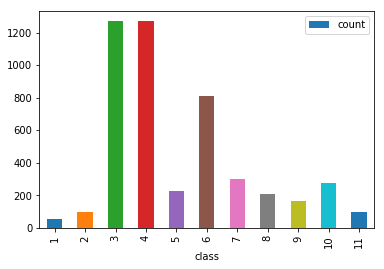

In [2]:
x = []
y = []
for key, item in df_train.groupby('class'):
    x.append(key)
    y.append(len(item))
    
df_distribution = pd.DataFrame(data={'class': x, 'count': y})
df_distribution.plot(kind='bar', x='class', y='count')

#### 可以看出来数据集里实例的分布并不均匀, 分类为3, 4, 6的实例占了大多数. 所以在后续的处理过程中要避免数据分布对结果的影响.

### 2.2 查看分词的出现频率
把所有描述的分词放到一起,查看在整个数据集中分词分布的情况.

In [3]:
"""
    加载停用词列表,后面会对分词结果进行过滤.
"""
with open('./stop_words.txt', 'r') as f:
    lines = f.readlines()
    
stop_words = [x[:-1] for x in lines]

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import collections
import re
%matplotlib inline

def restore_tokens_from_text(text):
    """
        由于Excel里读取出来的数据都是string类型,这里我们把文本转换成list.
    """
    regex_to_list = r"[\[\',\]\(\)）（]"
    space_separated_string = re.sub(regex_to_list, '', text)
    return space_separated_string.split(' ')

def get_word_list_from_dataframe(df, col_name):
    """
        遍历DataFrame的一列,把所有的token存放到一个list里面.
    """
    w_list = []
    for idx, row in df.iterrows():
        w_list += restore_tokens_from_text(row[col_name])
    return w_list
    

In [5]:
get_word_list_from_dataframe(df_train.head(), col_name='merged_tokens')

['合晟资产',
 '专注',
 '股票',
 '债券',
 '二级市场',
 '投资',
 '合格',
 '投资者',
 '资产',
 '管理',
 '企业',
 '业务范围',
 '资产',
 '管理',
 '投资',
 '咨询',
 '投资',
 '顾问',
 '管理',
 '私募基金',
 '股票型',
 '债券型',
 '资产',
 '管理',
 '计划',
 '证券投资',
 '基金',
 '管理',
 '总资产',
 '规模',
 '80亿元',
 '中国证券投资基金业协会',
 '数据',
 '管理',
 '私募证券投资基金',
 '顾问',
 '管理',
 '类',
 '规模',
 '较大',
 '管理',
 '规模',
 '处于',
 '50亿元',
 '第一',
 '梯队',
 '中',
 '小微企业',
 '个体',
 '工商户',
 '农户',
 '贷款',
 '设立',
 '发生',
 '变化',
 '立足于',
 '商业地产',
 '商业地产',
 '开发',
 '销售',
 '运营',
 '全产业链',
 '一整套',
 '增值',
 '业务',
 '覆盖',
 '商业',
 '定位',
 '策划',
 '商业',
 '设计',
 '销售代理',
 '招商',
 '代理',
 '电子商务',
 '商业地产',
 '运管',
 '互联网',
 '电商',
 '模式',
 'O2O',
 '线上',
 '导流',
 '线下服务',
 '方式',
 '住宅类',
 '业务',
 '创新',
 '营销',
 '业务',
 '板块',
 '商业地产',
 '策划',
 '顾问',
 '招商',
 '运营',
 '管理',
 '代理',
 '销售',
 '麦吉铺',
 'O2O',
 '电子商务',
 '工商管理部门',
 '核准',
 '经营范围',
 '投资',
 '咨询',
 '经济',
 '信息',
 '咨询',
 '企业管理',
 '咨询',
 '品牌',
 '推广',
 '策划',
 '公共关系策划',
 '文化交流',
 '策划',
 '咨询',
 '企业形象',
 '策划',
 '图文',
 '设计',
 '会展',
 '依法',
 '须经',
 '批准',
 '项目',
 '部门',
 '批准',
 '后方',
 '经营',
 

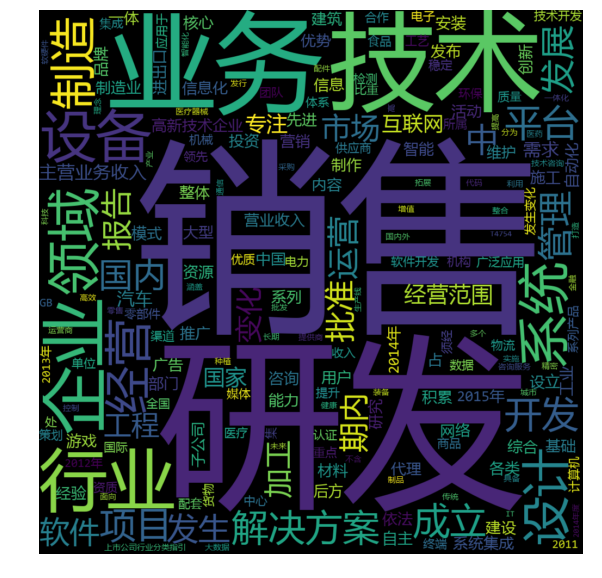

In [6]:
word_list = get_word_list_from_dataframe(df=df_train, col_name='merged_tokens')
word_freq = collections.Counter(word_list)

wordcloud = WordCloud(height=1000, width=1000, margin=0, font_path='./YaHeiConsolas.ttf').generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### 在第一次的处理中发现有些词对于公司介绍来说太常见,并不能对任何分类结果有参考作用:
- 公司
- 产品
- 服务
- 生产
- 包括
- 提供
- 多年
- 建立
- 依托
- 致力于
- 主营业务
- 有限公司
...

所以需要对停用词进行更新,然后再次分词.

#### 再次过滤掉一些常用词以后,查看分词出现频率的分布情况

一共有 41844 个分词


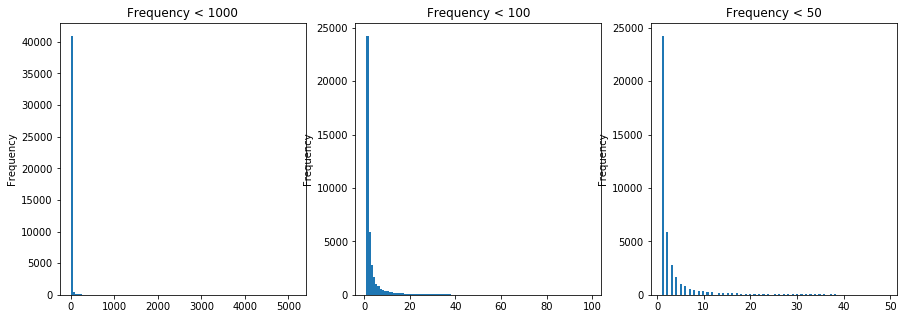

In [7]:
print('一共有 {0} 个分词'.format(str(len(word_freq))))
df_token_dist = pd.DataFrame(data={'token': list(word_freq.keys()), 'frequency': list(word_freq.values())})
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
df_token_dist['frequency'].plot(bins=100, kind='hist', title='Frequency < 1000')
plt.subplot(1,3,2)
df_token_dist[df_token_dist['frequency'] < 100]['frequency'].plot(kind='hist', bins=100, title='Frequency < 100')
plt.subplot(1,3,3)
df_token_dist[df_token_dist['frequency'] < 50]['frequency'].plot(kind='hist', bins=100, title='Frequency < 50')
plt.show()

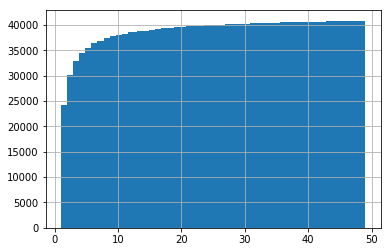

In [8]:
df_token_dist[df_token_dist['frequency'] < 50]['frequency'].hist(cumulative=True, bins=100)

#### 可以看出:
- 百分之九十的分词出现次数都是小于20的.
- 有一半以上的分词只出现了一次.

#### 对只出现过一次的分词进行过滤

In [9]:
df_token_for_onehot = df_token_dist[df_token_dist['frequency'] > 1]
len(list(df_token_for_onehot['token']))

17603

## 3. 编码尝试与结果评估

### 3.1 OneHot编码

在对文本数据进行分词处理之后,我们的模型依旧无法直接对这些分词进行处理,我们需要再一次的对分词的结果进行处理,转换成数值型的值,以便我们的模型可以进行计算.

OneHot编码是一种比较常用的编码方式,其主要作用是把分类数据以0-1值的向量进行表示,而且也可以通过1值的下标来代表所属类别.这样既可以把类别转换成数值,也不会让计算机误解数值大小所表达的意思.比如:男性类别的下标为1,女性类别下标为2,通过数值来表述男女之间的关系是没有意义的.

In [10]:
# 开始对分词结果进行OneHot编码.

from numpy import argmax
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def transform_tokens(tokens, token_set):
    """
        如果出现新的分词(即训练集上没有出现过的,或者只出现过一次的分词)则把该分词置为'UNKNOWN'
    """
    return [t if t in token_set else 'UNKNOWN' for t in tokens]

def process_onehot(tokens, lbl_model, oh_model, unique_tokens):
    """
        tokens代表一条数据的分词结果.
    """
    tokens_final = transform_tokens(tokens, unique_tokens)
    lbl_encoded = lbl_model.transform(tokens_final)
    return oh_model.transform(lbl_encoded.reshape(len(lbl_encoded), 1))

# 首先把所有的分词组合到一起.这里word_freq.keys()的值是去重过后的分词集合.
unique_tokens = list(df_token_for_onehot['token'])
unique_tokens.append('UNKNOWN')

# 由于OneHot Encoder只能处理数值型数据,所以这里需要通过LabelEncoder把分词转换成数值.
label_encoder = LabelEncoder()
label_model = label_encoder.fit(unique_tokens)
label_encoded = label_model.transform(unique_tokens)

# 对LabelEncoder处理过的分词进行OneHot编码.
onehot_encoder = OneHotEncoder(sparse=False)
# 注意: OneHotEncoder只接受 n x 1的二维数组,所以我们需要对label_encoded进行一次reshape的操作.
onehot_model = onehot_encoder.fit(label_encoded.reshape(len(label_encoded), 1))

In [11]:
tokens_str = df_train.loc[0]['merged_tokens']
# 从Excel里读出来的是string,所以要做一个转换,从而获取token的一个list.
tokens = restore_tokens_from_text(tokens_str)
tokens_onehot = process_onehot(tokens, label_model, onehot_encoder, unique_tokens)

# 由于OneHot模型空间里的分词太多,无法对向量进行展示,这里只输出第一个分词对应的下标.
for row in tokens_onehot:
    for i in range(len(row)):
        if row[i] > 0:
            print("row: ", row[i-5: i+5])
    break
    
# 输出第一条数据分词的数值表示(数值代表该分词在整个向量里的坐标)
print("Shape: ", str(tokens_onehot.shape))
print(tokens_onehot)

row:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Shape:  (46, 17604)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
tokens

['合晟资产',
 '专注',
 '股票',
 '债券',
 '二级市场',
 '投资',
 '合格',
 '投资者',
 '资产',
 '管理',
 '企业',
 '业务范围',
 '资产',
 '管理',
 '投资',
 '咨询',
 '投资',
 '顾问',
 '管理',
 '私募基金',
 '股票型',
 '债券型',
 '资产',
 '管理',
 '计划',
 '证券投资',
 '基金',
 '管理',
 '总资产',
 '规模',
 '80亿元',
 '中国证券投资基金业协会',
 '数据',
 '管理',
 '私募证券投资基金',
 '顾问',
 '管理',
 '类',
 '规模',
 '较大',
 '管理',
 '规模',
 '处于',
 '50亿元',
 '第一',
 '梯队']

### 3.2 Embedding编码

One of the benefits of using dense and low-dimensional vectors is computational:
the majority of neural network toolkits do not play well with very high-dimensional sparse vectors. ... 
The main benefit of the dense representations is generalization power. If we believe some featrues may provide similar clues, it is worthwhile to provide a representation that is able to capture these similarities.

- Page 92, Neural Network Methods in Natural Language Processing, 2017.

Embedding编码也是对文本在向量空间进行表示的一种方法.区别于OneHot编码,Embedding的维度是可以调节的,表述数据的向量不是稀疏的,每个维度都是有意义的.这样做的好处是:
1. 增加了向量表述的灵活性(维度可控).
2. 避免数据过于稀疏对计算空间的浪费.
3. 可以有能力对数据的相关性进行计算.

#### 下面开始对分词结果进行Embedding处理
为了后续的可视化操作,这里会把embedding的维度定为2.

In [13]:
import gensim
from gensim.models.word2vec import Word2Vec
from bokeh.io import output_notebook
from bokeh.plotting import show, figure

In [14]:
all_token_lists = df_train['merged_tokens'].apply(restore_tokens_from_text).tolist()
w2v_model_128_dims = Word2Vec(sentences=all_token_lists, size=128, sg=1, window=10, min_count=2, seed=11, workers=4)


In [15]:
w2v_model_128_dims.save('w2v_model.w2v')

In [16]:
all_token_lists[:5]

[['合晟资产',
  '专注',
  '股票',
  '债券',
  '二级市场',
  '投资',
  '合格',
  '投资者',
  '资产',
  '管理',
  '企业',
  '业务范围',
  '资产',
  '管理',
  '投资',
  '咨询',
  '投资',
  '顾问',
  '管理',
  '私募基金',
  '股票型',
  '债券型',
  '资产',
  '管理',
  '计划',
  '证券投资',
  '基金',
  '管理',
  '总资产',
  '规模',
  '80亿元',
  '中国证券投资基金业协会',
  '数据',
  '管理',
  '私募证券投资基金',
  '顾问',
  '管理',
  '类',
  '规模',
  '较大',
  '管理',
  '规模',
  '处于',
  '50亿元',
  '第一',
  '梯队'],
 ['中', '小微企业', '个体', '工商户', '农户', '贷款', '设立', '发生', '变化'],
 ['立足于',
  '商业地产',
  '商业地产',
  '开发',
  '销售',
  '运营',
  '全产业链',
  '一整套',
  '增值',
  '业务',
  '覆盖',
  '商业',
  '定位',
  '策划',
  '商业',
  '设计',
  '销售代理',
  '招商',
  '代理',
  '电子商务',
  '商业地产',
  '运管',
  '互联网',
  '电商',
  '模式',
  'O2O',
  '线上',
  '导流',
  '线下服务',
  '方式',
  '住宅类',
  '业务',
  '创新',
  '营销',
  '业务',
  '板块',
  '商业地产',
  '策划',
  '顾问',
  '招商',
  '运营',
  '管理',
  '代理',
  '销售',
  '麦吉铺',
  'O2O',
  '电子商务'],
 ['工商管理部门',
  '核准',
  '经营范围',
  '投资',
  '咨询',
  '经济',
  '信息',
  '咨询',
  '企业管理',
  '咨询',
  '品牌',
  '推广',
  '策划',
  '公共关系策划',
  '文化交流',
  '策

#### 查看分词的embedding表示

In [17]:
w2v_model_128_dims['销售']

/home/alvin/.conda/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.02952151,  0.26164526,  0.00413834,  0.08445837, -0.15219231,
       -0.50660115,  0.09652182, -0.1883459 ,  0.04934939,  0.39821777,
        0.3257911 ,  0.35557085, -0.4535601 , -0.45925   , -0.11663189,
       -0.41423962,  0.07365388, -0.22776031,  0.10492177,  0.13669941,
        0.25170848, -0.10162119, -0.06901655, -0.29655233,  0.10191091,
        0.06511265, -0.3611572 ,  0.49857938, -0.12462109,  0.42815787,
        0.36638772, -0.06883301, -0.00216444,  0.37377   , -0.09982147,
        0.03392814,  0.29055473, -0.15963604, -0.3182709 ,  0.15303351,
       -0.01848828,  0.7256935 , -0.10770227,  0.0309936 , -0.09528799,
       -0.29723135,  0.46890467,  0.2025227 ,  0.06073283,  0.26838794,
        0.0575972 , -0.21967302, -0.14939944, -0.32349452, -0.36536154,
       -0.43733132,  0.01819336,  0.05053934,  0.30189484,  0.05124273,
        0.18667789, -0.23483428, -0.298811  ,  0.43776122, -0.20704606,
       -0.24060915,  0.28979772,  0.22537935,  0.20680282,  0.43

In [18]:
w2v_model_128_dims.most_similar('银行')

/home/alvin/.conda/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('金融机构', 0.941319465637207),
 ('金融', 0.8950515985488892),
 ('政府机构', 0.8860264420509338),
 ('公共事业', 0.8843518495559692),
 ('金融保险', 0.8805897235870361),
 ('投资者', 0.8645836114883423),
 ('政府部门', 0.8605853915214539),
 ('商业银行', 0.8597177863121033),
 ('政府', 0.8594015836715698),
 ('最终用户', 0.8575848937034607)]

#### 可以看出embedding编码对数据相关性的判断还是有一定效果的.

#### 对embedding的结果进行降维,并进行可视化操作

In [19]:
from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from bokeh.plotting import show, figure

X = w2v_model_128_dims[w2v_model_128_dims.wv.vocab]
tsne = TSNE(n_components=2, n_iter=300)
X_2d = tsne.fit_transform(X)


/home/alvin/.conda/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [20]:
coords_df = pd.DataFrame(X_2d, columns=['x', 'y'])
coords_df['token'] = w2v_model_128_dims.wv.vocab.keys()
coords_df.head()

,x,y,token
0,0.543401,-2.522606,专注
1,2.186681,-4.018194,股票
2,1.690659,-5.191144,债券
3,1.874809,-4.795619,二级市场
4,0.537981,-6.022102,投资


In [21]:
output_notebook()

Loading BokehJS ...

In [22]:
subset_df = coords_df.sample(n=5000)
p = figure()
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)

In [24]:
show(p)